# WIP

### reference: https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
from scipy.stats import multivariate_normal
from scipy.stats import norm
from numpy import random as rd
from scipy import stats

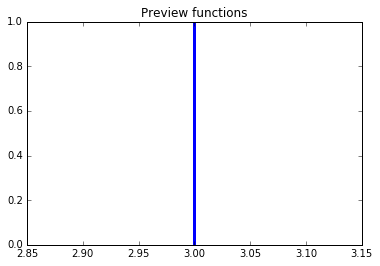

"\nNexp = [100, 1000, 100000]\nNrem = [20, 100, 10000]\n\nfor k in range(len(Nexp)):\n    n = Nexp[k]\n    r = Nrem[k]\n    s,w = comp_w(n)\n    accu = np.copy(w)\n    for i in range(1, n):\n        accu[i] += accu[i - 1]\n    \n    samples = []\n    for i in range(r):\n        index = np.searchsorted(accu, rd.uniform())\n        samples.append(s[index])\n    \n    kernel = stats.gaussian_kde(samples)\n    # plt.plot(s, w, '.')\n    x = np.linspace(0, 3.5, 200)\n    plt.plot(x, kernel(x), label='SIR', lw=2)\n    plt.plot(x, q(x), label='prior', lw=2)\n    plt.plot(x, pz(x), label='funcion real (posterior)', lw=2)\n    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)\n    plt.title('Using %d samples, re-sample %d' % (n, r))\n    plt.show()\n"

In [2]:
mu = 3
var = 0.5
sig = np.sqrt(var)
N = 100
y = rd.normal(mu, sig, N)

# prior 
mup = 2
lap = 2

# hyperparameters
mu0 = 1
k0 = 1
a0 = 1
b0 = 0.4

def posterior(mu0, k0, a0, b0, n):
    x = y[0:n]
    muml = np.sum(x) / n
    mun = (k0 * mu0 + n * muml) / (k0 + n)
    kn = k0 + n
    an = a0 + n / 2.0
    bn = b0 + 0.5 * np.sum((x - muml) ** 2) + (k0 * n * ((muml - mu0) ** 2)) / (2 * (k0 + n))
    return mun, kn, an, bn


mun, kn, an, bn = posterior(mu0, k0, a0, b0, len(y))


def Zng(mu0, k0, a0, b0):
    '''Computes the normalization constant of the normal-gamma dist'''
    ft = sp.special.gamma(a0) / (b0 **  a0)
    return ft * ((2.0 * np.pi) / k0) ** (0.5)
    
    
def norm_gamma(x, la, mu0, k0, a0, b0):
    zng = Zng(mu0, k0, a0, b0)
    a = la ** (a0 - 0.5)
    return (1.0 / zng) * a * np.exp(- (la / 2.0) * (k0 * ((x - mu0) ** 2) + 2.0 * b0))


def q(x, la):
    return norm_gamma(x, la, mu0, k0, a0, b0)
    
def draw_q(n):
    lambdas = rd.gamma(a0, b0, n)
    mus = []
    for l in lambdas : 
        mus.append(rd.normal(mu0, 1.0 / (k0 * l)))
    return mus, lambdas
        

def pt(z):
    pass
    
def pz(x, la): 
    return norm_gamma(x, la, mun, kn, an, bn)

def comp_w(n):
    s = draw_q(n)
    w = pt(s) / q(s)
    den = np.sum(w)
    w = w / den
    assert (abs(np.sum(w) - 1) < 1e-10)
    return s, w



def preview_functions():
    plt.axvline(x=mu, color='b', linewidth=3)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Preview functions')
    plt.show()
    
preview_functions()

'''
Nexp = [100, 1000, 100000]
Nrem = [20, 100, 10000]

for k in range(len(Nexp)):
    n = Nexp[k]
    r = Nrem[k]
    s,w = comp_w(n)
    accu = np.copy(w)
    for i in range(1, n):
        accu[i] += accu[i - 1]
    
    samples = []
    for i in range(r):
        index = np.searchsorted(accu, rd.uniform())
        samples.append(s[index])
    
    kernel = stats.gaussian_kde(samples)
    # plt.plot(s, w, '.')
    x = np.linspace(0, 3.5, 200)
    plt.plot(x, kernel(x), label='SIR', lw=2)
    plt.plot(x, q(x), label='prior', lw=2)
    plt.plot(x, pz(x), label='funcion real (posterior)', lw=2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Using %d samples, re-sample %d' % (n, r))
    plt.show()
'''

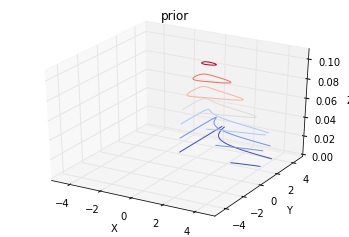

In [37]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

mus = np.linspace(0, 5, 200)
var = np.linspace(0, 5, 200)
z = np.ndarray(shape=(len(mus),len(var)), dtype=float)
for i in range(len(mus)):
    for j in range(len(var)):
        z[i][j] = q(mus[i], var[j])
        
# ax.plot_surface(mus, var, z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(mus, var, z, zdir='z', cmap=cm.coolwarm)
# cset = ax.contour(mus, var, z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contour(mus, var, z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim((-5, 5))
ax.set_ylabel('Y')
ax.set_ylim((-5, 5))
ax.set_zlabel('Z')
ax.set_title('prior')

plt.show()

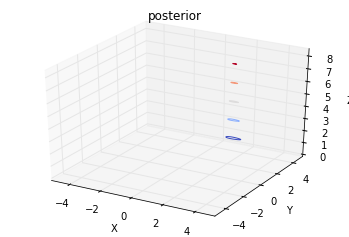

In [38]:
fig = plt.figure()
ax = fig.gca(projection='3d')

mus = np.linspace(0, 5, 200)
var = np.linspace(0, 5, 200)
z = np.ndarray(shape=(len(mus),len(var)), dtype=float)
for i in range(len(mus)):
    for j in range(len(var)):
        z[i][j] = pz(mus[i], var[j])
        
# ax.plot_surface(mus, var, z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(mus, var, z, zdir='z', cmap=cm.coolwarm)
# cset = ax.contour(np.array([mus]), var, z, zdir='x', cmap=cm.coolwarm)
# cset = ax.contour(np.array([mus]), np.array([var]), z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim((-5, 5))
ax.set_ylabel('Y')
ax.set_ylim((-5, 5))
ax.set_zlabel('Z')
ax.set_title('posterior')

plt.show()